#**Motor Imagery EEG Signal Analysis for Finger Movement: An Approach to Brain-Computer Interfaces**

---
`In this study, we aimed to classify finger movements using brain signals captured through EEG. We focused on five distinct classes of finger movements: Thumb, Index, Middle, Ring, and Pinky. Utilizing CNN + Transformers for feature extraction from EEG data, we reduced the complexity by using only 4 channels out of the original 64. This reduction was achieved before applying Continuous Wavelet Transform (CWT) analysis with the Morlet mother wavelet and a scale of 10
`



In [ ]:
# Eng/Amr Mostafa Omar
# Nile University ,Cairo, Egypt
# Data 20/6/2024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.callbacks import Callback
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import RobustScaler
import gc
import psutil
import os
import scipy.io
import pywt

##**Step 1: Load Data**

In [ ]:
# Step 1: Loading Data
def load_data_from_mat(mat_file_path):
    mat_data = scipy.io.loadmat(mat_file_path)
    data = mat_data['Data'][0, 0]
    X = data['trials']  # EEG data (256, 64, 900)
    y = data['Labels'].flatten()  # Target labels (900,)
    Fs = data['Fs'][0, 0]  # Sampling frequency
    Channels = [ch[0] for ch in data['Channels'][0]]  # EEG channels
    return X, y, Fs, Channels

mat_file_paths = [
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_1.mat',
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_2.mat',
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_3.mat',
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_4.mat',
    '/content/drive/MyDrive/Dataset_Fingers_EEG_mat/Supplementary Materials/Folder 1/Power_Spectrum_trials_subject_5.mat'
]

X_all = []
Y_all = []

for mat_file_path in mat_file_paths:
    X, y, Fs, Channels = load_data_from_mat(mat_file_path)
    X_all.append(X)
    Y_all.append(y)

X = np.concatenate(X_all, axis=2)
y = np.concatenate(Y_all)

print("Combined EEG Data Shape (Trials):", X.shape)
print("Combined Labels Shape:", y.shape)
print("Sampling Frequency:", Fs)
print("Channels:", Channels)


Combined EEG Data Shape (Trials): (256, 64, 4542)
Combined Labels Shape: (4542,)
Sampling Frequency: 256
Channels: ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'TP9', 'TP10', 'FT9', 'FT10']


##**Step 2: Preprocess Data**

In [ ]:
# Preprocessing
lowcut = 8.0
highcut = 30.0
order = 5

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

filtered_data = np.zeros_like(X)
for trial in range(X.shape[2]):
    for channel in range(X.shape[1]):
        filtered_data[:, channel, trial] = bandpass_filter(X[:, channel, trial], lowcut, highcut, Fs, order=order)

mean_signal = np.mean(filtered_data, axis=1, keepdims=True)
filtered_data -= mean_signal

selected_channels = ['T7',  'TP7','PO3',  'PO7']

channel_indices = [Channels.index(ch) for ch in selected_channels]
filtered_data_selected = filtered_data[:, channel_indices, :]

print("Filtered and CAR Processed Data Shape (Selected Channels):", filtered_data_selected.shape)

reshaped_data = filtered_data_selected.reshape(-1, filtered_data_selected.shape[1])
scaler = RobustScaler()
scaled_data = scaler.fit_transform(reshaped_data)
scaled_data_3d = scaled_data.reshape(filtered_data_selected.shape)

print("Scaled Data Shape (Selected Channels):", scaled_data_3d.shape)


Filtered and CAR Processed Data Shape (Selected Channels): (256, 4, 4542)
Scaled Data Shape (Selected Channels): (256, 4, 4542)


##**Step 3: Split Data into Classes**

In [ ]:
def assign_data_to_class(class_label, scaled_data_3d, y, percentage=0.25):
    target_trials = scaled_data_3d[:, :, y == class_label]
    num_target_trials = target_trials.shape[2]

    num_non_target_trials_per_class = int(percentage * num_target_trials)
    non_target_trials = []
    for other_class_label in range(1, 6):
        if other_class_label != class_label:
            other_class_trials = scaled_data_3d[:, :, y == other_class_label]
            non_target_trials.append(other_class_trials[:, :, :num_non_target_trials_per_class])
    non_target_trials = np.concatenate(non_target_trials, axis=2)

    combined_trials = np.concatenate((target_trials, non_target_trials), axis=2)
    combined_labels = np.array([1] * num_target_trials + [0] * non_target_trials.shape[2])
    return combined_trials, combined_labels

X_thumb, Y_thumb = assign_data_to_class(1, scaled_data_3d, y)
X_index, Y_index = assign_data_to_class(2, scaled_data_3d, y)
X_middle, Y_middle = assign_data_to_class(3, scaled_data_3d, y)
X_ring, Y_ring = assign_data_to_class(4, scaled_data_3d, y)
X_pinky, Y_pinky = assign_data_to_class(5, scaled_data_3d, y)

print("Thumb Data Shape (Trials):", X_thumb.shape, "Labels Shape:", Y_thumb.shape)
print("Index Data Shape (Trials):", X_index.shape, "Labels Shape:", Y_index.shape)
print("Middle Data Shape (Trials):", X_middle.shape, "Labels Shape:", Y_middle.shape)
print("Ring Data Shape (Trials):", X_ring.shape, "Labels Shape:", Y_ring.shape)
print("Pinky Data Shape (Trials):", X_pinky.shape, "Labels Shape:", Y_pinky.shape)


Thumb Data Shape (Trials): (256, 4, 1810) Labels Shape: (1810,)
Index Data Shape (Trials): (256, 4, 1817) Labels Shape: (1817,)
Middle Data Shape (Trials): (256, 4, 1817) Labels Shape: (1817,)
Ring Data Shape (Trials): (256, 4, 1817) Labels Shape: (1817,)
Pinky Data Shape (Trials): (256, 4, 1817) Labels Shape: (1817,)


##**Step 4: Split Data into Training and Testing Sets**

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(trials, labels):
    train_trials, test_trials, train_labels, test_labels = train_test_split(
        trials.transpose(2, 0, 1), labels, test_size=0.2, random_state=42, stratify=labels)
    train_trials = train_trials.transpose(1, 2, 0)
    test_trials = test_trials.transpose(1, 2, 0)
    return train_trials, test_trials, train_labels, test_labels

X_train_thumb, X_test_thumb, Y_train_thumb, Y_test_thumb = split_data(X_thumb, Y_thumb)
X_train_index, X_test_index, Y_train_index, Y_test_index = split_data(X_index, Y_index)
X_train_middle, X_test_middle, Y_train_middle, Y_test_middle = split_data(X_middle, Y_middle)
X_train_ring, X_test_ring, Y_train_ring, Y_test_ring = split_data(X_ring, Y_ring)
X_train_pinky, X_test_pinky, Y_train_pinky, Y_test_pinky = split_data(X_pinky, Y_pinky)

print("Thumb Train Data Shape (Trials):", X_train_thumb.shape, "Train Labels Shape:", Y_train_thumb.shape)
print("Thumb Test Data Shape (Trials):", X_test_thumb.shape, "Test Labels Shape:", Y_test_thumb.shape)
print("Index Train Data Shape (Trials):", X_train_index.shape, "Train Labels Shape:", Y_train_index.shape)
print("Index Test Data Shape (Trials):", X_test_index.shape, "Test Labels Shape:", Y_test_index.shape)
print("Middle Train Data Shape (Trials):", X_train_middle.shape, "Train Labels Shape:", Y_train_middle.shape)
print("Middle Test Data Shape (Trials):", X_test_middle.shape, "Test Labels Shape:", Y_test_middle.shape)
print("Ring Train Data Shape (Trials):", X_train_ring.shape, "Train Labels Shape:", Y_train_ring.shape)
print("Ring Test Data Shape (Trials):", X_test_ring.shape, "Test Labels Shape:", Y_test_ring.shape)
print("Pinky Train Data Shape (Trials):", X_train_pinky.shape, "Train Labels Shape:", Y_train_pinky.shape)
print("Pinky Test Data Shape (Trials):", X_test_pinky.shape, "Test Labels Shape:", Y_test_pinky.shape)


Thumb Train Data Shape (Trials): (256, 4, 1448) Train Labels Shape: (1448,)
Thumb Test Data Shape (Trials): (256, 4, 362) Test Labels Shape: (362,)
Index Train Data Shape (Trials): (256, 4, 1453) Train Labels Shape: (1453,)
Index Test Data Shape (Trials): (256, 4, 364) Test Labels Shape: (364,)
Middle Train Data Shape (Trials): (256, 4, 1453) Train Labels Shape: (1453,)
Middle Test Data Shape (Trials): (256, 4, 364) Test Labels Shape: (364,)
Ring Train Data Shape (Trials): (256, 4, 1453) Train Labels Shape: (1453,)
Ring Test Data Shape (Trials): (256, 4, 364) Test Labels Shape: (364,)
Pinky Train Data Shape (Trials): (256, 4, 1453) Train Labels Shape: (1453,)
Pinky Test Data Shape (Trials): (256, 4, 364) Test Labels Shape: (364,)


#**Step 5: Apply Continuous Wavelet Transform (CWT)**

In [ ]:
def apply_cwt(data):
    scales = np.arange(1, 101)  #  scales from 1 to 100
    cwt_coeffs = []
    for trial in data.transpose(2, 1, 0):  # Transpose to (trials, channels, samples)
        trial_coeffs = []
        for channel in trial:
            coeffs, freqs = pywt.cwt(channel, scales, 'morl')  # wavelet 'morl'
            trial_coeffs.append(coeffs)
        cwt_coeffs.append(trial_coeffs)
    cwt_coeffs = np.array(cwt_coeffs)
    # Transpose to get shape (trials, samples, coefficients, channels)
    cwt_coeffs = cwt_coeffs.transpose(0, 2, 3, 1)
    return cwt_coeffs

##**Step 6 :Train and Evaluate Transformers + CNN model**

In [ ]:
# Memory management functions
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")

def clear_memory():
    gc.collect()
    print_memory_usage()

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_memory()

# Transformer block for numerical data
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define datasets and labels (as per your current setup)
datasets = {
    'thumb': (X_train_thumb, X_test_thumb, Y_train_thumb, Y_test_thumb),
    'index': (X_train_index, X_test_index, Y_train_index, Y_test_index),
    'middle': (X_train_middle, X_test_middle, Y_train_middle, Y_test_middle),
    'ring': (X_train_ring, X_test_ring, Y_train_ring, Y_test_ring),
    'pinky': (X_train_pinky, X_test_pinky, Y_train_pinky, Y_test_pinky),
}

results = {}

thumb Train CWT Data for cnn Shape: (1448, 100, 256, 4)
thumb Test CWT Data for cnn Shape: (362, 100, 256, 4)
thumb Train CWT Data for trans Shape: (1448, 100, 1024)
thumb Test CWT Data  for trans Shape : (362, 100, 1024)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 256, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 98, 254, 32)          1184      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 49, 127, 32)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 47, 125, 64)          18496     ['max_pooling2d[0][0]']   

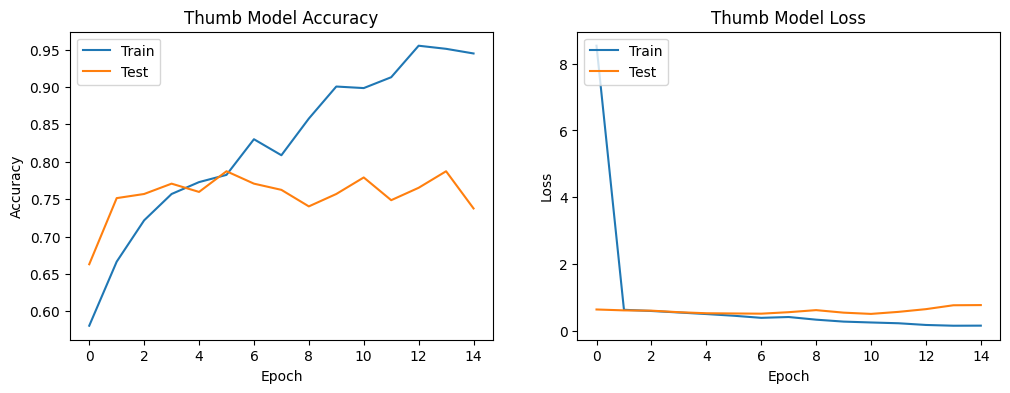

12/12 [==============================] - 1s 34ms/step


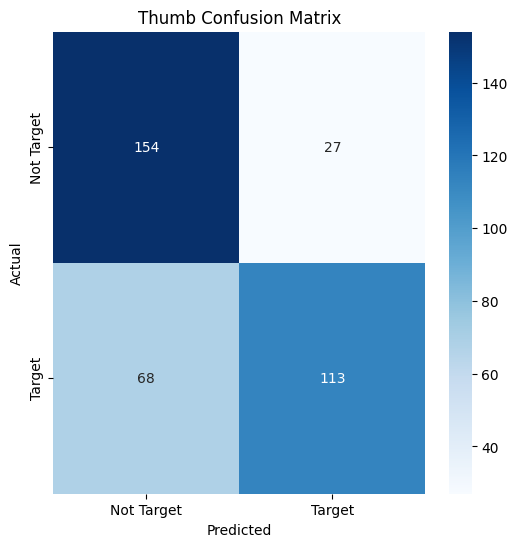

Thumb Classification Report:
              precision    recall  f1-score   support

  Not Target       0.69      0.85      0.76       181
      Target       0.81      0.62      0.70       181

    accuracy                           0.74       362
   macro avg       0.75      0.74      0.73       362
weighted avg       0.75      0.74      0.73       362

Memory usage: 4803.47 MB
index Train CWT Data for cnn Shape: (1453, 100, 256, 4)
index Test CWT Data for cnn Shape: (364, 100, 256, 4)
index Train CWT Data for trans Shape: (1453, 100, 1024)
index Test CWT Data  for trans Shape : (364, 100, 1024)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100, 256, 4)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 98, 254, 32)          1184      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 49, 127, 32)          0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 47, 125, 64)          18496     ['max_pooling2d_2[0][0]'

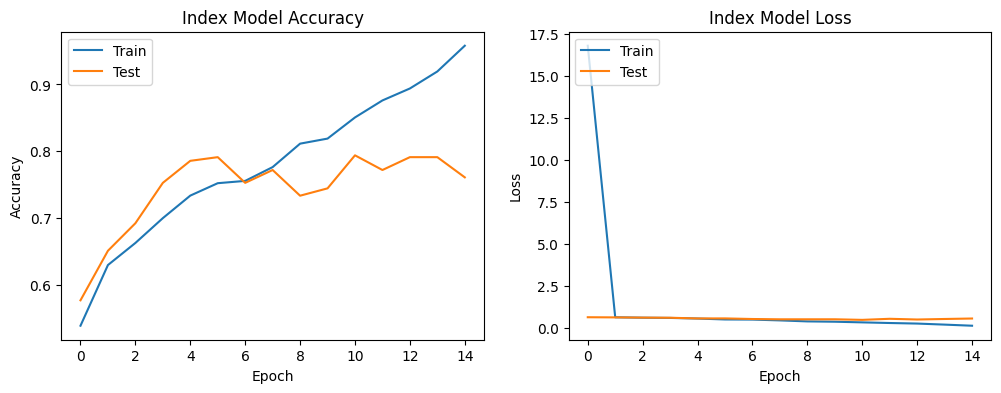

12/12 [==============================] - 1s 39ms/step


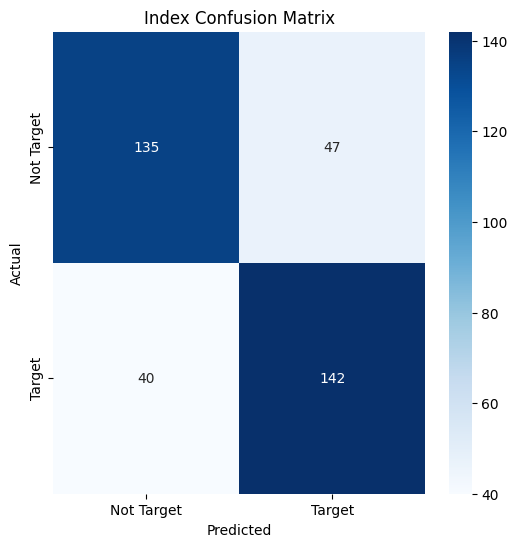

Index Classification Report:
              precision    recall  f1-score   support

  Not Target       0.77      0.74      0.76       182
      Target       0.75      0.78      0.77       182

    accuracy                           0.76       364
   macro avg       0.76      0.76      0.76       364
weighted avg       0.76      0.76      0.76       364

Memory usage: 4922.37 MB
middle Train CWT Data for cnn Shape: (1453, 100, 256, 4)
middle Test CWT Data for cnn Shape: (364, 100, 256, 4)
middle Train CWT Data for trans Shape: (1453, 100, 1024)
middle Test CWT Data  for trans Shape : (364, 100, 1024)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100, 256, 4)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 98, 254, 32)          1184      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 49, 127, 32)          0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 47, 125, 64)          18496     ['max_pooling2d_4[0][0]'

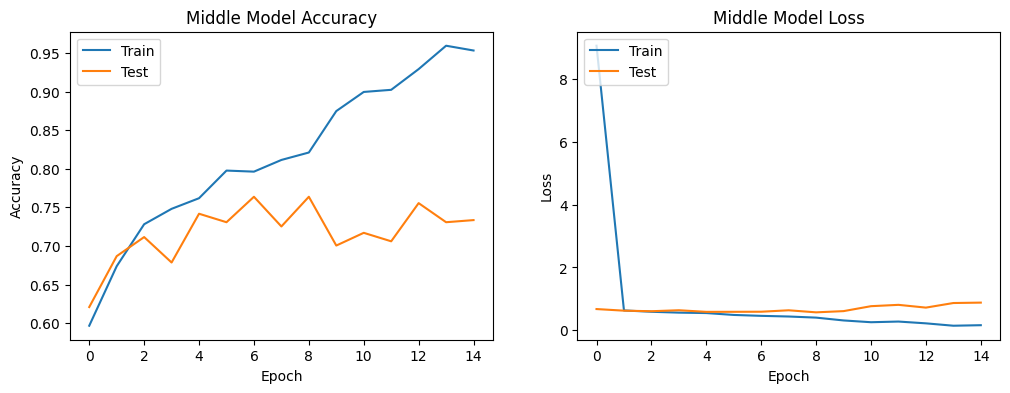

12/12 [==============================] - 1s 29ms/step


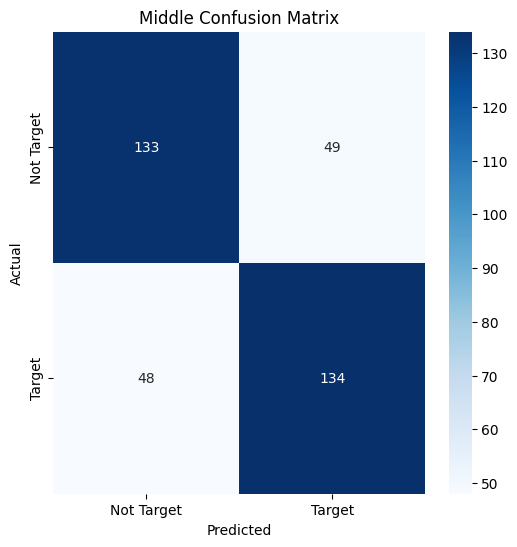

Middle Classification Report:
              precision    recall  f1-score   support

  Not Target       0.73      0.73      0.73       182
      Target       0.73      0.74      0.73       182

    accuracy                           0.73       364
   macro avg       0.73      0.73      0.73       364
weighted avg       0.73      0.73      0.73       364

Memory usage: 5190.82 MB
ring Train CWT Data for cnn Shape: (1453, 100, 256, 4)
ring Test CWT Data for cnn Shape: (364, 100, 256, 4)
ring Train CWT Data for trans Shape: (1453, 100, 1024)
ring Test CWT Data  for trans Shape : (364, 100, 1024)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 100, 256, 4)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 98, 254, 32)          1184      ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 49, 127, 32)          0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 47, 125, 64)          18496     ['max_pooling2d_6[0][0]'

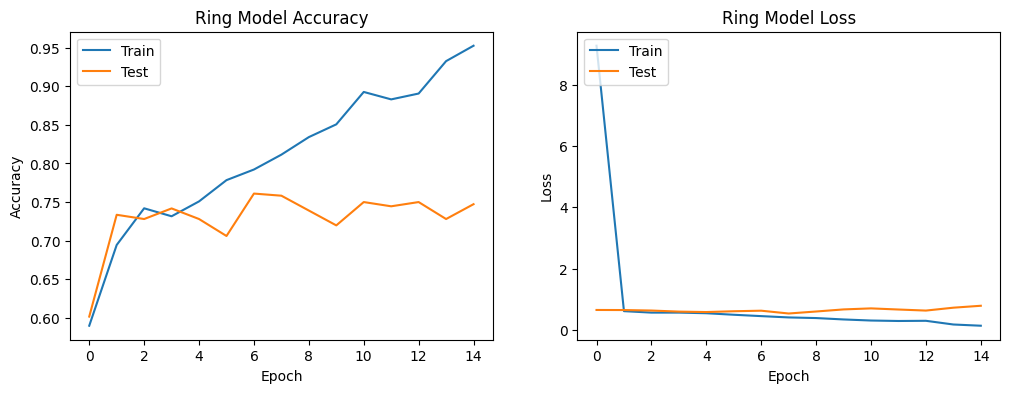

12/12 [==============================] - 1s 29ms/step


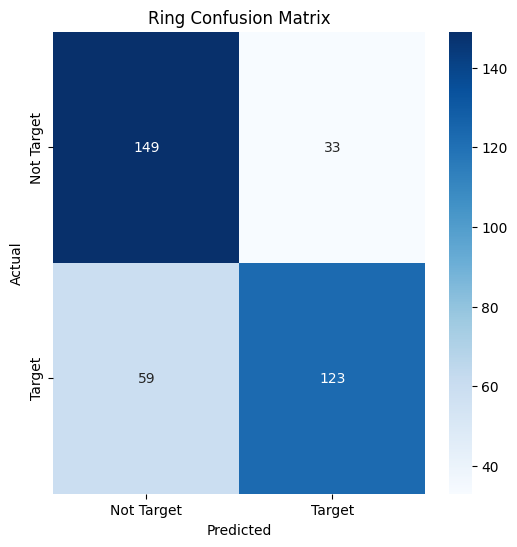

Ring Classification Report:
              precision    recall  f1-score   support

  Not Target       0.72      0.82      0.76       182
      Target       0.79      0.68      0.73       182

    accuracy                           0.75       364
   macro avg       0.75      0.75      0.75       364
weighted avg       0.75      0.75      0.75       364

Memory usage: 5174.31 MB
pinky Train CWT Data for cnn Shape: (1453, 100, 256, 4)
pinky Test CWT Data for cnn Shape: (364, 100, 256, 4)
pinky Train CWT Data for trans Shape: (1453, 100, 1024)
pinky Test CWT Data  for trans Shape : (364, 100, 1024)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 100, 256, 4)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 98, 254, 32)          1184      ['input_9[0][0]']             
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 49, 127, 32)          0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 47, 125, 64)          18496     ['max_pooling2d_8[0][0]'

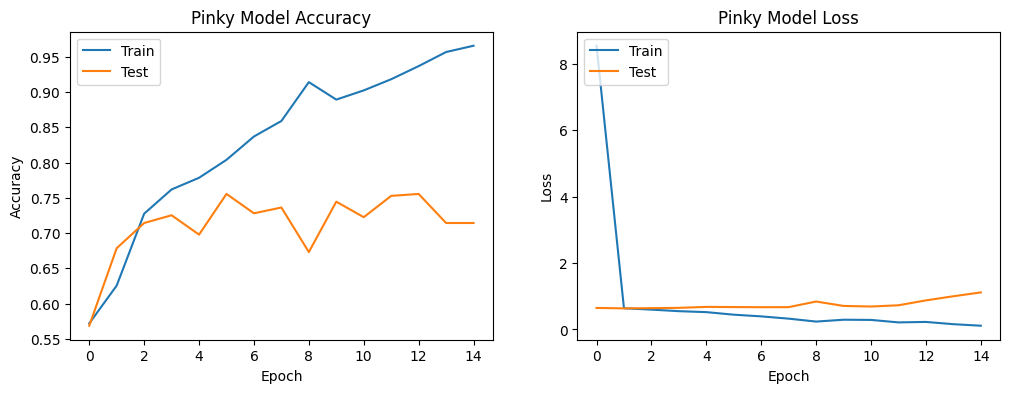

12/12 [==============================] - 1s 40ms/step


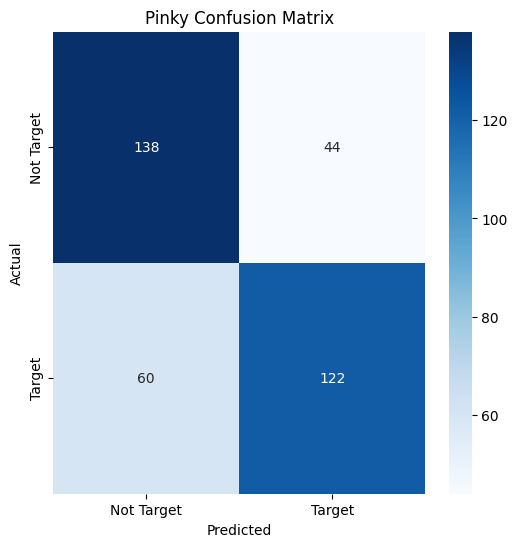

Pinky Classification Report:
              precision    recall  f1-score   support

  Not Target       0.70      0.76      0.73       182
      Target       0.73      0.67      0.70       182

    accuracy                           0.71       364
   macro avg       0.72      0.71      0.71       364
weighted avg       0.72      0.71      0.71       364

Memory usage: 5649.16 MB
Final accuracies:
thumb: 0.7376
index: 0.7610
middle: 0.7335
ring: 0.7473
pinky: 0.7143


In [ ]:
for finger, (X_train, X_test, Y_train, Y_test) in datasets.items():

    X_train_cwt_cnn = apply_cwt(X_train)
    X_test_cwt_cnn = apply_cwt(X_test)

    # Reshape the data
    X_train_cwt_trans = np.reshape(X_train_cwt_cnn, (-1, 100, 256 * 4))
    X_test_cwt_trans = np.reshape(X_test_cwt_cnn, (-1, 100, 256 * 4))

    print(f"{finger} Train CWT Data for cnn Shape:", X_train_cwt_cnn.shape)
    print(f"{finger} Test CWT Data for cnn Shape:", X_test_cwt_cnn.shape)

    print(f"{finger} Train CWT Data for trans Shape:", X_train_cwt_trans.shape)
    print(f"{finger} Test CWT Data  for trans Shape :", X_test_cwt_trans.shape)



    # Define CNN model
    cnn_input = Input(shape=(100,256, 4))
    cnn_output = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    cnn_output = MaxPooling2D((2, 2))(cnn_output)
    cnn_output = Conv2D(64, (3, 3), activation='relu')(cnn_output)
    cnn_output = MaxPooling2D((2, 2))(cnn_output)
    cnn_output = Flatten()(cnn_output)
    cnn_output = Dense(128, activation='relu')(cnn_output)

    # Define Transformer model for numerical data
    trans_input = Input(shape=(100, 256 * 4))
    trans_output = TransformerBlock(embed_dim=1024, num_heads=2, ff_dim=128)(trans_input)
    trans_output = Flatten()(trans_output)
    trans_output = Dense(128, activation='relu')(trans_output)

    # Concatenate CNN and Transformer outputs
    combined_features = concatenate([cnn_output, trans_output])

    # Final classification layer
    output = Dense(1, activation='sigmoid')(combined_features)

    # Define the hybrid model
    model = Model(inputs=[cnn_input, trans_input], outputs=[output])

    # Compile the model
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train the model
    history = model.fit([X_train_cwt_cnn, X_train_cwt_trans], Y_train, epochs=15, batch_size=32, validation_data=([X_test_cwt_cnn, X_test_cwt_trans], Y_test), callbacks=[ClearMemory()])

    # Evaluate the model
    loss, accuracy = model.evaluate([X_test_cwt_cnn, X_test_cwt_trans], Y_test)
    results[finger] = accuracy
    print(f"Accuracy for {finger}: {accuracy:.4f}")

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{finger.capitalize()} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{finger.capitalize()} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    # Predict the values from the test set
    Y_pred = (model.predict([X_test_cwt_cnn, X_test_cwt_trans]) > 0.5).astype("int32")

    # Confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Target', 'Target'], yticklabels=['Not Target', 'Target'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{finger.capitalize()} Confusion Matrix')
    plt.show()

    # Classification report
    print(f'{finger.capitalize()} Classification Report:')
    print(classification_report(Y_test, Y_pred, target_names=['Not Target', 'Target']))

    # Clear memory
    del X_train_cwt_cnn, X_test_cwt_cnn, X_train_cwt_trans, X_test_cwt_trans
    clear_memory()

# Print final accuracies
print("Final accuracies:")
for finger, accuracy in results.items():
    print(f"{finger}: {accuracy:.4f}")